# From Language to Lyrics

## Introduction

[Quote?] Human beings have spent millennia attempting to express themselves through poetry and music. Often, emotions and thoughts find the purest form when they are funneled through a creative outlet. Even those who do not create can appreciate the artwork of others and with the advent of social media, numerous platforms have arisen to help people connect based on these mutually shared interests. Genius is one such service. Genius is a platform that "breaks down text with line-by-line annotations, added and edited by anyone in the world. It's your interactive guide to human culture." (http://genius.com/Genius-about-genius-annotated).

## Problem Statement

This is undoubtedly an extremely useful tool for anyone who wants to learn more about their favorite piece of text. However, in order for the platform to be successful, experts who have in-depth knowledge about a given topic need to provide high quality annotations for others to read. **How does one go about connecting users with the content they are best suited to annotate?** Using information about the text in question as well as the past annotations of users, I created a recommendation engine that will rank the most qualified user(s) to annotate a new piece of text when it is added to the site. Not only is this useful for Genius, but has more general applicability to any platform looking to utilize user input to help clarify question about a topic (Wikipedia, Quora, etc.)

## Data Sources

The data used from this project was gathered from the Genius website, which has an API available to get data about songs, annotations, artists, and users. The Python requests library was used to pull data from the API and parse through the JSON responses.

**Process**

1. Generate API Key through registration
2. Request Artist ID by searching for artist name
3. Request song information for the artist
4. Request annotation and referent information for each song
5. Store results in a SQL database

In order to constrain the problem, I focused specific on lyrics from top selling hip-hop artists. I created the list of artists by pulling from the names from the top 50 best selling rap albums (http://www.complex.com/music/2013/05/the-50-best-selling-rap-albums) and by looking at the top charting hip-hop albums of the last 2 years on Billboard (http://www.billboard.com/archive/charts/2015/r-b-hip-hop-albums).


## Loading Python Libraries

In [179]:
import pickle as pic
from collections import Counter
import numpy as np
import seaborn as sb
import nltk, string
import pandas as pd
from gensim import corpora, models, similarities
from nltk.corpus import stopwords
import gensim
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
from __future__ import division
plt.style.use('ggplot')
% matplotlib inline

## Loading/Cleaning Data

We will be loading a dataframe that has already combined the data from the song, referent, and annotation tables. The text for the referents and annotations were converted to ascii from utf8 in order to remove special characters to make the text preprocessing easier. A number of observation were dropped where the referent referred to something other than lyrics in a song (i.e. song title, artist who sang the current verse, demarcation of the beginning of the chorus, etc.). Artists who were not in the first quartile in terms of number of referents were removed because during the data gathering process a number of songs where the orginal artists were featured were also pulled. By restricting the dataset in this way, I was able to remove the vast majority of artists who were only included because they had a feature from one of the top artists. Additionally, there were a few rows with missing texts from the referent or annotation that were also dropped.

In [107]:
# Loading Data From Pickle
all_data = pic.load(open("../Data/all_data.p"))
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147256 entries, 0 to 147255
Data columns (total 36 columns):
song_id           147256 non-null int64
title             147256 non-null object
artist            147256 non-null object
artist_id         147256 non-null int64
ref_id            147256 non-null int64
classification    147256 non-null object
fragment          147256 non-null object
is_description    147256 non-null bool
annotator_id      147256 non-null int64
ann_id            147256 non-null float64
ann_text          147256 non-null object
has_voters        147256 non-null object
comment_count     147256 non-null float64
votes_total       147256 non-null float64
ann_lda_1         147256 non-null float32
ann_lda_2         147256 non-null float32
ann_lda_3         147256 non-null float32
ann_lda_4         147256 non-null float32
ann_lda_5         147256 non-null float32
ann_lda_6         147256 non-null float32
ann_lda_7         147256 non-null float32
ann_lda_8         147256

Function for decoding text:

In [ ]:
# Change UTF-8 to ASCII
# Define Genius Decoder Function
def genius_decoder(x):
    if x:
        return x.decode('utf8').encode('ascii', 'ignore')
    else:
        return x

Function for removing rows where referent are not actual lyrical snippet. These are denoted by the brackets at the beginning and the end of the string

In [31]:
# Identify referents that are titles, headers, or notes instead of actual lyrics
def is_lyrics(frag):
    if frag[0] == "[" and frag[-1] == "]":
        return False
    else:
        return True

5 examples of referents and their associated annotations:

In [108]:
# Sample of Lyrics and Annotations
sample = all_data.sample(n=5, random_state=11)[['artist', 'title', 'fragment', 'ann_text']].reset_index(drop=True)
for i in range(5):
    print "Artist: ", sample['artist'][i], "\n"
    print "Title: ", sample['title'][i], "\n"
    print "Lyrics: ", sample['fragment'][i], "\n"
    print "Annotation:", sample['ann_text'][i], "\n"
    print "\n---\n"

Artist:  Snoop Dogg 

Title:  Candy (Drippin' Like Water) 

Lyrics:  Pies 

Annotation: Kilo. 


---

Artist:  Lil Wayne 

Title:  CoCo 

Lyrics:  I send my goons to kill somebody, I need head proof 

Annotation: If Wayne puts a hit on someone, he wants proof that the job was completed via severed head. Guess he isnt the only one to get the job done. 


---

Artist:  Eminem 

Title:  That's All She Wrote (Solo Version) 

Lyrics:  (Faygo's cheaper) 

Annotation: Its not unusual of Eminem to make subliminal shots in his raps. He has had a long dispute with the hip hop group Insane Clown Posse, and they are loyal Faygo supporters, and do a lot of advertisement for them. So what hes saying here is that they are garbage, and nowhere near to his lyrical caliber. Which I think most people, including me, would undoubtedly agree on. 


---

Artist:  Wu-Tang Clan 

Title:  For Heaven's Sake 2000 

Lyrics:  Murder rap 

Annotation: His raps are so good that they are murderous 


---

Artist:  Swi

## Exploratory Data Analysis

After performing some initial cleaning of the data, we want to get a better idea of its structure, which will help inform our decisions on the best strategy to identify which users are the most qualified to annotate a given referent. 

### Who are the most prevalent artists by number of referents?

                  artist  num_of_refs
0              Lil Wayne        17850
1                 Eminem        13190
2                  Jay Z         9876
3             Kanye West         8276
4                   2Pac         7638
5                  Drake         7463
6                 Future         4600
7           Wu-Tang Clan         4344
8                50 Cent         4301
9   The Notorious B.I.G.         3357
10              Ludacris         2973
11            Snoop Dogg         2853
12               OutKast         2803
13          Beastie Boys         2201
14                   DMX         1899


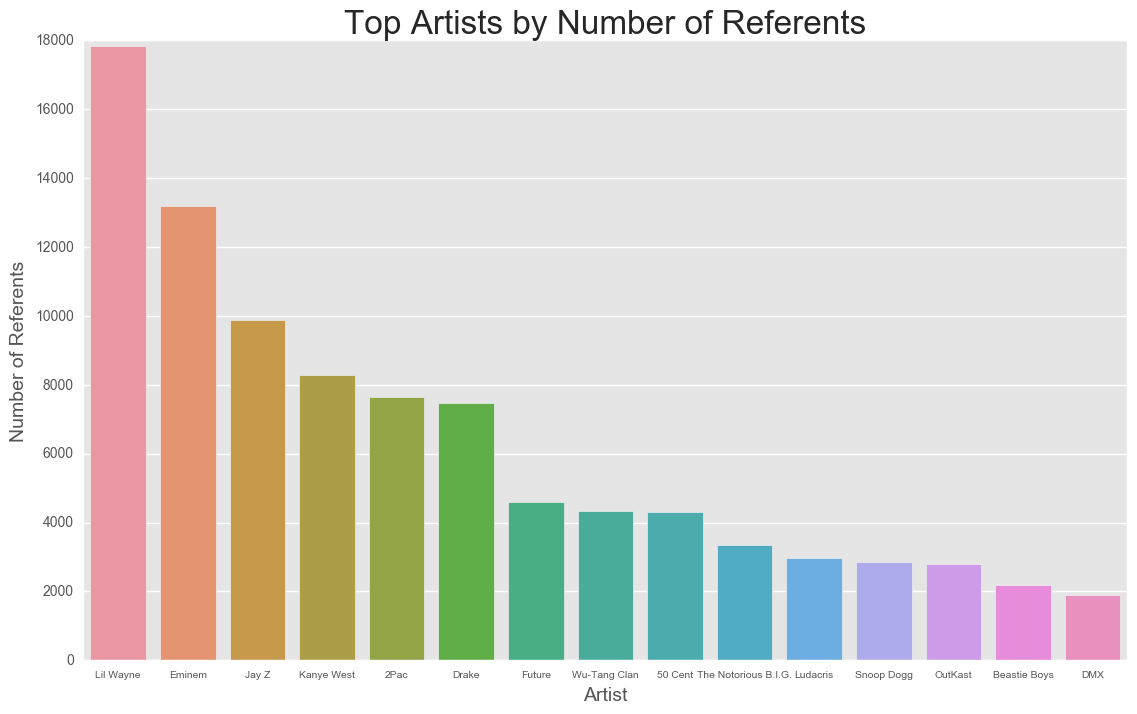

In [191]:
top_10_artists = all_data.groupby('artist').size().sort_values(ascending=False)[:15].reset_index()
top_10_artists.rename(columns={0: 'num_of_refs'}, inplace=True)
print top_10_artists
plt.figure(figsize=(12,8))
sb.barplot(x='artist', y="num_of_refs", data=top_10_artists)
plt.xlabel('Artist', fontsize=14)
plt.xticks(fontsize=7.5)
plt.ylabel('Number of Referents', fontsize=14)
plt.title('Top Artists by Number of Referents', fontsize=24)
plt.savefig('../Images/top_artists_by_referents.png')

These results are in line with artists originally chosen for the dataset. We can see that Lil' Wayne has been particularly prolific with 17850 referents in total.

### How do the lengths of referents compare to their annotations?

One might initially expect that the annotation would be significant longer than the referent itself, but it would helpful to quantify and visualize that difference. Both the distributions of length are highly negatively skewed, so  a log transformation is used to make the visualizations clearer

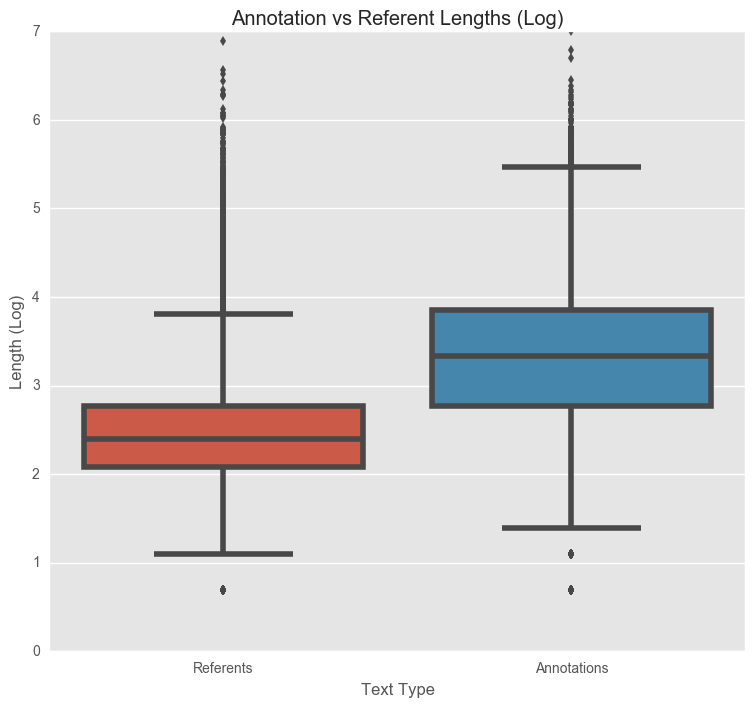

In [192]:
text_data = all_data[['fragment', 'ann_text']]
text_data.rename(columns={'fragment': 'Referents', 'ann_text': 'Annotations'}, inplace=True)
text_data_long = pd.melt(text_data)
text_data_long['Length (Log)'] = text_data_long['value'].apply(lambda x: np.log1p(len(x.split())))
plt.figure(figsize=(8,8))
sb.boxplot(x = 'variable', y = 'Length (Log)', data=text_data_long)
plt.xlabel('Text Type')
plt.title('Annotation vs Referent Lengths (Log)')
plt.savefig('../Images/annotation_referent_length.png')

In [194]:
text_data['Annotation Length'] = text_data['Annotations'].apply(lambda x: len(x.split()))
text_data['Referent Length'] = text_data['Referents'].apply(lambda x: len(x.split()))
print text_data['Annotation Length'].describe()
print text_data['Referent Length'].describe()

/Users/nehemiahloury/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


count    147256.000000
mean         36.002411
std          32.857167
min           1.000000
25%          15.000000
50%          27.000000
75%          46.000000
max        1095.000000
Name: Annotation Length, dtype: float64
count    147256.000000
mean         12.817671
std          14.181841
min           1.000000
25%           7.000000
50%          10.000000
75%          15.000000
max         985.000000
Name: Referent Length, dtype: float64


/Users/nehemiahloury/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [202]:
print all_data['artist'][44594]

2Pac


Also of interest is the relationship between the length of a referent and its associated annotation. We can define a *length ratio* which is equal to the length of the annotation over the length of the referent. Below, we can see the distribution of length ratio for our data. From the descriptive statistics we can see that on average, annotations are 4 times as long as their associated referent.

count    147256.000000
mean          4.307405
std           8.338383
min           0.001475
25%           1.454545
50%           2.600000
75%           4.727273
max         811.000000
dtype: float64


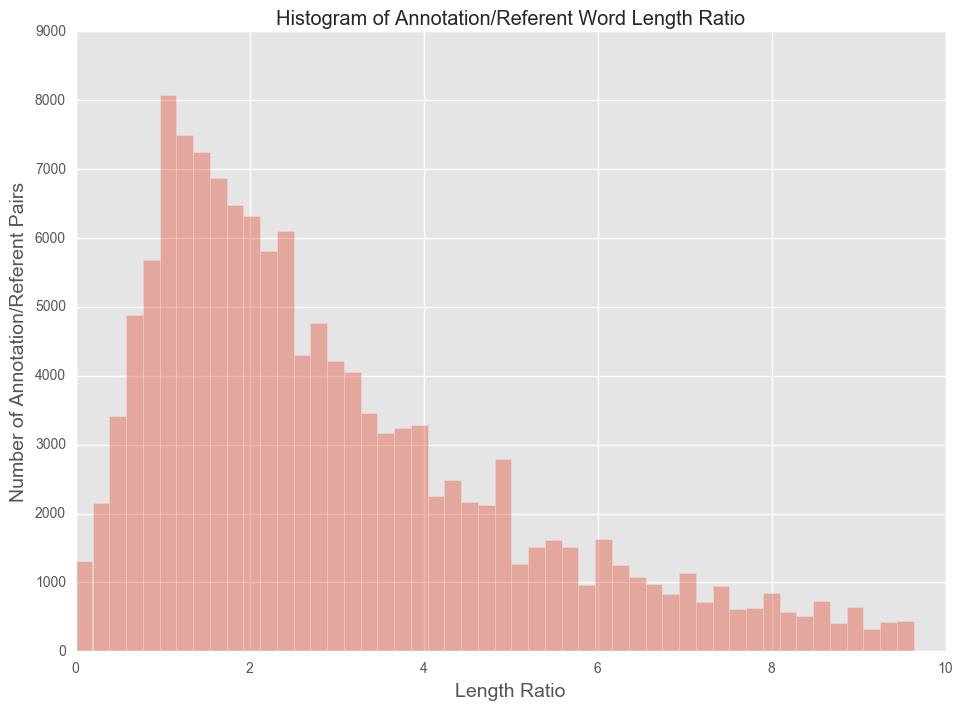

In [193]:
# Create Length Ratio
length_ratio = text_data.apply(lambda x: len(x['Annotations'].split()) / len(x['Referents'].split()), axis=1)

# Descriptive Statistics
print length_ratio.describe()

# Remove Outliers for Plotting
length_ratio_iqr = np.percentile(length_ratio, 75) - np.percentile(length_ratio, 25)
length_ratio = length_ratio[length_ratio < np.percentile(length_ratio, 75) + 1.5 * length_ratio_iqr]


# Plot Results
plt.figure(figsize=(10,8))
sb.distplot(length_ratio, kde=False)
plt.xlabel('Length Ratio', fontsize=14)
plt.ylabel('Number of Annotation/Referent Pairs', fontsize=14)
plt.title('Histogram of Annotation/Referent Word Length Ratio')
plt.savefig('../Images/hist_annotation_word_length_ratio.png')

## Generating/Exploring User Features

One of the main problems about the data is that user level information is not available beyond a unique user id being attached to each referent. That means user features need to be generated from the available song, referent, and annotation level data. The generated user features can be grouped into four categories:


1. Vote Features
2. Comment Features
3. Basic Annotation Features
4. LDA Annotation Features

The vote and comment features consist of descriptive information about the amount of votes and comments that a user has received on their annotations. The basic annotation features consist of data about the length of the annotations by word and by character. Finally, the LDA annotation features are simply the average LDA topic value for each user. The creation of these features is specified below:



### What are the Most Popular Words in Referents and Annotations?

Now that we have some idea about the distribution of referent and annotation length, we want to know about what is actually being said in those pieces of text. The simplest way to look at this is simply by looking at the counts of the most frequent words. Below, we see words ranking by their occurrence in referents and annotations after removing common stopwords in english along with punctuation and then stemming the words so that all forms of a given word (i.e. run, runs, running, etc.) are counted as the same word.

In [136]:
# Define stemmer
stemmer = nltk.stem.porter.PorterStemmer()

# Define Stopwords
stop = set(stopwords.words('english'))

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens if item not in stop]

# Define function to tokenize text and remove punctuaction and stopwords
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(None, string.punctuation)))

# Get text from DataFrame
ann_text = all_data['ann_text'].values
ref_text = all_data['fragment'].values

# Normalize Text
ann_text_bow = map(normalize, ann_text)
ref_text_bow = map(normalize, ref_text)

# Get Word Counts
ann_text_word_count = Counter([word for text in ann_text_bow for word in text])
ref_text_word_count = Counter([word for text in ref_text_bow for word in text])

NameError: name 'text' is not defined

In [165]:
# Print Top 25 Words and their counts in annotations
ann_text_word_count.most_common(25)

[(u'like', 25564),
 (u'he', 22999),
 (u'get', 19929),
 (u'also', 19446),
 (u'refer', 18750),
 (u'say', 17791),
 (u'song', 16837),
 (u'one', 16370),
 (u'line', 16255),
 (u'make', 14720),
 (u'wayn', 14316),
 (u'money', 13200),
 (u'peopl', 13048),
 (u'use', 12947),
 (u'time', 12910),
 (u'go', 11408),
 (u'mean', 11238),
 (u'rap', 11229),
 (u'want', 10982),
 (u'girl', 10950),
 (u'jay', 9787),
 (u'drake', 9440),
 (u'would', 9340),
 (u'know', 9322),
 (u'even', 8994)]

In [164]:
# Print Top 25 Words and their counts in referents
ref_text_word_count.most_common(25)

[(u'im', 24146),
 (u'like', 19650),
 (u'nigga', 16665),
 (u'got', 14774),
 (u'get', 12492),
 (u'dont', 10514),
 (u'know', 9334),
 (u'aint', 8316),
 (u'fuck', 8219),
 (u'shit', 7453),
 (u'bitch', 7146),
 (u'caus', 6164),
 (u'go', 6061),
 (u'back', 5519),
 (u'see', 5515),
 (u'make', 5041),
 (u'na', 4976),
 (u'one', 4971),
 (u'say', 4752),
 (u'that', 4649),
 (u'man', 4395),
 (u'let', 4371),
 (u'yeah', 4333),
 (u'time', 4237),
 (u'come', 4200)]

In [158]:
# Join texts together for wordcloud creation
all_anns = ' '.join(ann_text)
all_refs = ' '.join(ref_text)

# Create wordclouds
ann_wordcloud = WordCloud(width=800, height=400, prefer_horizontal=.6).generate(all_anns)
ref_wordcloud = WordCloud(width=800, height=400, prefer_horizontal=.6).generate(all_refs)

In [204]:
ann_wordcloud.to_file('../Images/annotation_wordcloud.png')

(-0.5, 799.5, 399.5, -0.5)

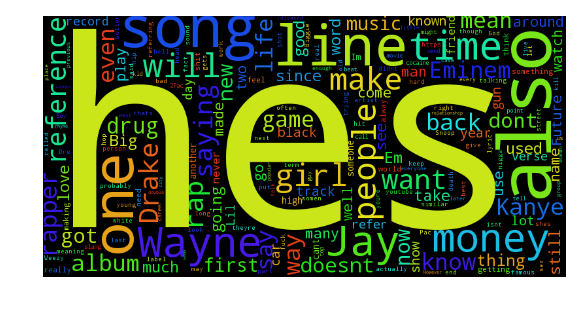

In [159]:
# Show annotation wordcloud
plt.imshow(ann_wordcloud)
plt.axis("off")

(-0.5, 799.5, 399.5, -0.5)

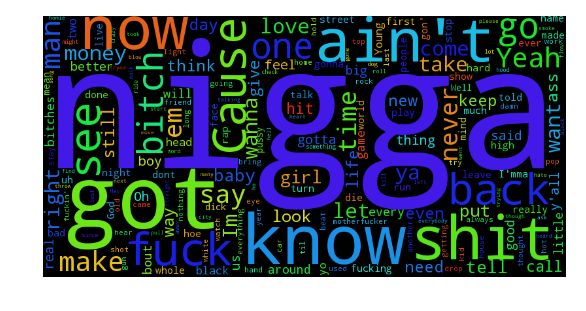

In [160]:
# Show referent wordcloud
plt.imshow(ref_wordcloud)
plt.axis("off")

In [205]:
ref_wordcloud.to_file('../Images/referent_wordcloud.png')

From looking at the top 25 words from the referents and annotation along with their wordclouds, we begin to see some patterns emerging. Annotations tend to focus on description, so there are frequent occurrences the artists' names, as well as vocabulary that could be used to describe a song (i.e. refer, mean, song, line etc.). On ther other hand, the most popular words in the referents themselves tend to be the aggressive, explicit vocabulary that has come to dominate rap over the past couple of decades. The most popular word in the referents, "I'm", likely takes the top spot because much of rap music focuses on the artist's standing in society, whether it be the quality of their reputation or the amount of possession they have acquired.

## Topic Modelling (Latent Dirichlet Allocation)

Now that we have a cursory understanding of what is going on in our text, what we can do is apply a language model on top of the text we currently have in order to get vector representation of our text. This is useful for a number of reasons:

1. Computers have a notoriously difficult time understanding natural language. If texts can be transformed into vectors, it opens up a vast number of computational possibilities which were previously unavailable.
2. Analyzing a large amount of text by hand may take an inordindate amount of time. Therefore, we need a method to gain information about a large amount of text quickly.
3. Numerical comparisons (i.e. distance metrics) can be used in order to compare similarities between texts
4. These vector representations can then be used as an input to another algorithm (like an algorithm for ranking users!) that require numerical input
5. The vector space we create can be explored visually to gain additional insight to the nature of the texts in question

One of the most common ways to create these vector representations of texts in the Natural Language Processing is by using a *topic model*. A topic model is a statistical model for discovering the abstract topics that occur in a collection of document. This can then be used to discover hidden semantic structures within a body of text.

Latent Dirichlet Allocation (LDA) is a topic model which represents documents as a mixture of topics with produce words with certain probabilities. It assumes that documents are created in the following fashion:

- Decide the number of words the document will have
- Create a topic mixture for the document (according to a Dirichlet distribution over a fixed set of K topic)
- Generate each word by first picking a topic and then sampling the words in that topic to generate the word itself

LDA assumes that the documents were created in this fashion and then backtracks in order to uncover the "latent" topics that are most likely to have generated the corpus of documents.

One of the difficulties of using LDA is that the user must set the number of topics in advance. The NLP has explored a variety of different metrics and measured their performance against human intuition for what the topics across a corpus should be in order to try to understand their effectiveness. For the referents and annotations, three metrics (per word perplexity, c_v coherence, and umass coherence) were used along with my own qualitative assements in order to decide the proper number of topics for each corpus. The results of the analysis (between 5 and 50 topics for referents and annotations were explored):

In [166]:
# Load Data

# Load models
ann_lda = pic.load(open("../Models/ann_lda_model.p"))
ref_lda = pic.load(open("../Models/ref_lda_model.p"))

# Load Corpuses
ann_corpus_bow = pic.load(open("../Models/ann_corpus_bow.p"))
ref_corpus_bow = pic.load(open("../Models/ref_corpus_bow.p"))
ann_corpus_lda = pic.load(open("../Models/ann_corpus_lda.p"))
ref_corpus_lda = pic.load(open("../Models/ref_corpus_lda.p"))

# Load Dictionaries
ann_dictionary = pic.load(open("../Models/ann_dictionary.p"))
ref_dictionary = pic.load(open("../Models/ref_dictionary.p"))

# Load Results
ann_results = pic.load(open("../Data/ann_lda_results.p"))
ref_results = pic.load(open("../Data/ref_lda_results.p"))

In [167]:
# Define Plotting Function
def create_line_plot(df, x, y, x_lab, y_lab, title):
    df.plot(x=x, y=y)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.legend([y_lab])
    plt.title(title)

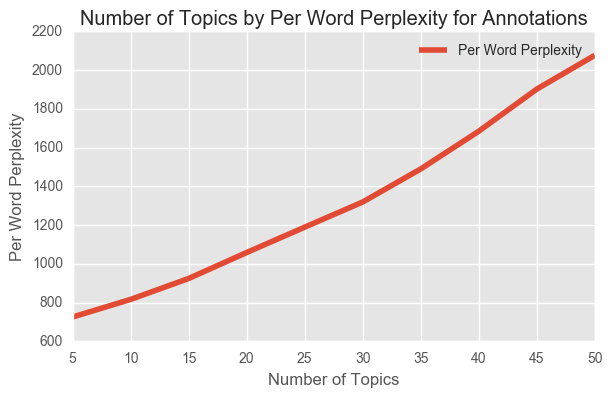

In [169]:
# Per Word Perplexity
create_line_plot(ann_results, "num_topics", "per_word_perplex", "Number of Topics",
             "Per Word Perplexity", "Number of Topics by Per Word Perplexity for Annotations")

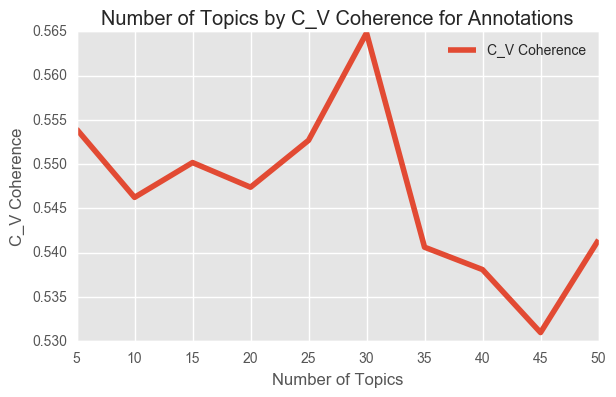

In [209]:
# Per Word Perplexity
create_line_plot(ann_results, "num_topics", "cv", "Number of Topics",
             "C_V Coherence", "Number of Topics by C_V Coherence for Annotations")
plt.savefig("../Images/ann_lda_cv.png")

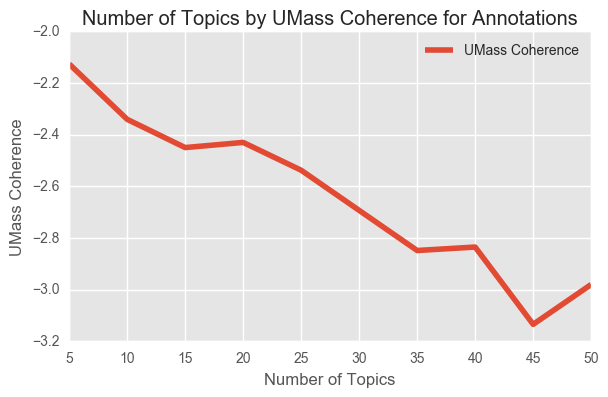

In [208]:
# Per Word Perplexity
create_line_plot(ann_results, "num_topics", "umass", "Number of Topics",
             "UMass Coherence", "Number of Topics by UMass Coherence for Annotations")
plt.savefig("../Images/ann_lda_umass.png")

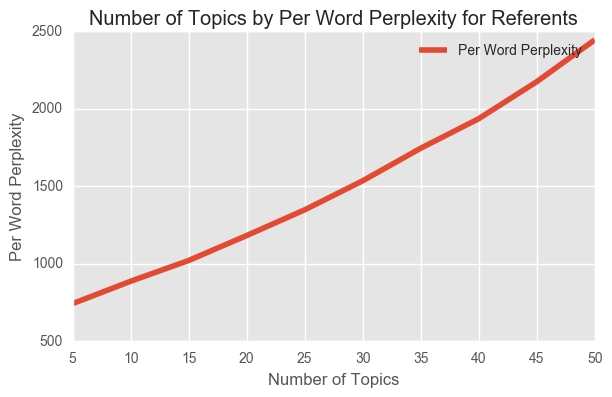

In [172]:
# Per Word Perplexity
create_line_plot(ref_results, "num_topics", "per_word_perplex", "Number of Topics",
             "Per Word Perplexity", "Number of Topics by Per Word Perplexity for Referents")

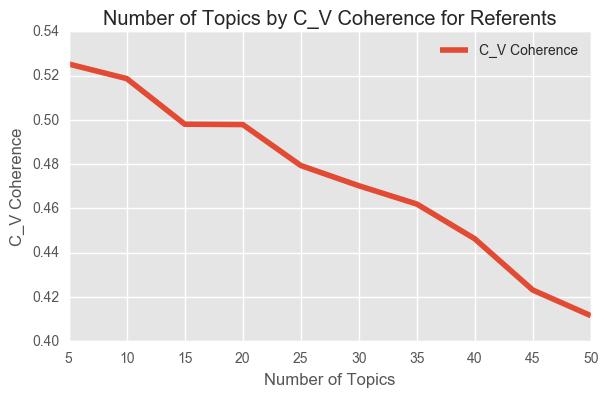

In [207]:
# Per Word Perplexity
create_line_plot(ref_results, "num_topics", "cv", "Number of Topics",
             "C_V Coherence", "Number of Topics by C_V Coherence for Referents")
plt.savefig("../Images/ref_lda_cv.png")

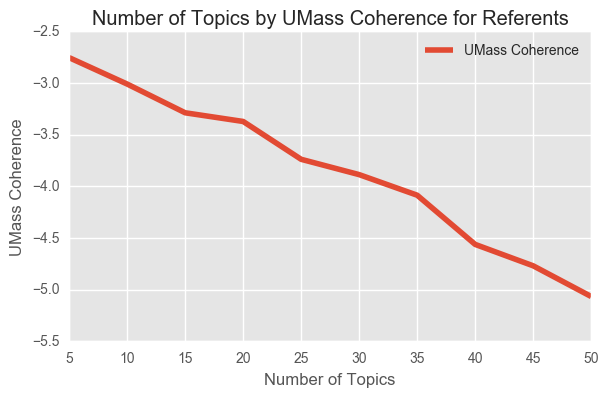

In [206]:
# Per Word Perplexity
create_line_plot(ref_results, "num_topics", "umass", "Number of Topics",
             "UMass Coherence", "Number of Topics by UMass Coherence for Referents")
plt.savefig("../Images/ref_lda_umass.png")

After comparing across these three metrics along with my own evaluation, I chose 12 topics for the annotations and 10 topics for the referents. Below, I've used pyLDAvis (a great tool for visually exploring topics) to create interactive visualizations of each final topic model.

In [180]:
# Prepare Annotation Visualization
ann_lda_vis = pyLDAvis.gensim.prepare(ann_lda, ann_corpus_bow, ann_dictionary)
pyLDAvis.display(ann_lda_vis)

In [181]:
# Prepare Referent Visualization
ref_lda_vis = pyLDAvis.gensim.prepare(ref_lda, ref_corpus_bow, ref_dictionary)
pyLDAvis.display(ref_lda_vis)